# WNTR / EPANET-MSX demo
This demo shows a simple example of multispecies chlorine decay taken from the 
EPANETMSX user manual. The Net3 example network from EPANET is used, and two 
different decay coefficients are assigned - one for each source of water.
The river uses decay coefficient k1, the lake uses decay coefficient k2, and 
the two values are an order of magnitude different. Once the initial example,
from the EPANETMSX user manual, has been run, parameter sensitivity is performed
to look at the impacts of different decay coefficients for the river source.

In [1]:
from pprint import pprint

### Load the network model, optionally remove EPANET quality

In [2]:
import wntr
wn = wntr.network.WaterNetworkModel('../networks/Net3.inp')
wn.options.quality.parameter = 'NONE'

### Add a new MSX model to the water network, set options

In [3]:
wn.add_msx_model()
wn.msx.title = 'Multisource Chlorine Decay'
wn.msx.references.append("""(2023) Shang F, L Rossman, and J Uber. 
"EPANET-MSX 2.0 User Manual". EPA/600/R-22/199""")
wn.msx.options.area_units = 'FT2'
wn.msx.options.rate_units = 'DAY'
wn.msx.options.timestep = 300

### Add the MSX reaction system information
This reaction system comes from the EPANET-MSX user manual. There are two species: Free Chlorine and a tracer. The tracer is used to select which decay coefficient is being used. The river is source 1, the lake is source 2.

The amount of free chlorine is based on the rate reaction below, 

In [4]:
T1 = wn.msx.add_species('T1','bulk',units='MG', note='Source 1 Tracer')
Cl2 = wn.msx.add_species('CL2','bulk', units='MG', note='Free Chlorine')
pprint(repr(Cl2))

("Species(name='CL2', species_type=<SpeciesType.BULK: 1>, units='MG', "
 "atol=None, rtol=None, note='Free Chlorine')")


In [5]:
k1 = wn.msx.add_constant('k1', 1.3, units='1/day')
k2 = wn.msx.add_constant('k2', 17.7, units='1/day')
pprint(repr(k2))

"Constant(name='k2', value=17.7, units='1/day')"


In [6]:
rxn_T1 = wn.msx.add_reaction('T1', 'pipe', 'rate', '0')
rxn_Cl2 = wn.msx.add_reaction('CL2', 'pipe', 'rate', '-(k1*T1 + k2*(1-T1))*CL2')
pprint(repr(rxn_Cl2))

("Reaction(species_name='CL2', expression_type=<ExpressionType.RATE: 2>, "
 "expression='-(k1*T1 + k2*(1-T1))*CL2')")


### Set up the initial quality
In this example, the initial quality is based on the two sources: the tracer, indicating which source is which, is set to 1.0 for the river; the chlorine is being boosted at the sources to the same level, 1.2 mg/L.

In [13]:
from wntr.msx.elements import InitialQuality
net_data = wn.msx.network_data
net_data.initial_quality['T1'] = InitialQuality(
    node_values={'River': 1.0}
)
net_data.initial_quality['CL2'] = InitialQuality(
    node_values={'River':1.2, 'Lake':1.2}
)
pprint(net_data.initial_quality)

{'CL2': InitialQuality(global_value=0.0, node_values=<2 entries>, link_values=<0 entries>),
 'T1': InitialQuality(global_value=0.0, node_values=<1 entries>, link_values=<0 entries>)}


### Run the simulation and view the results
With the MSX model attached to the WaterNetworkModel, there is nothing different in how the EpanetSimulator is called. Results are saved in keys with the species' name.

In [14]:
sim = wntr.sim.EpanetSimulator(wn)
res = sim.run_sim()
print('Node results:' , ', '.join([k for k in res.node.keys()]))
print('Link results:' , ', '.join([k for k in res.link.keys()]))

Node results:  demand, head, pressure, quality, T1, CL2
Link results:  quality, flowrate, velocity, headloss, status, setting, friction_factor, reaction_rate, T1, CL2


Generate some graphics that show how the river fraction changes through time.

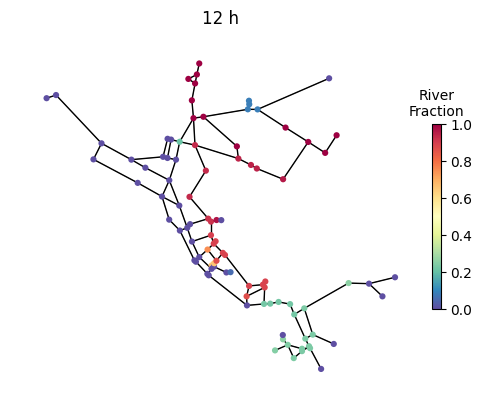

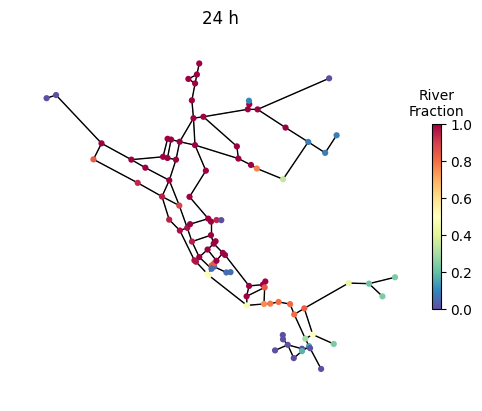

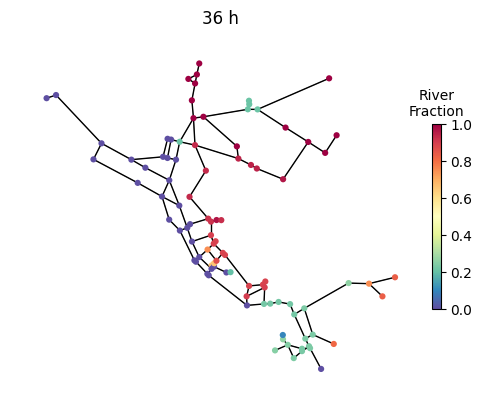

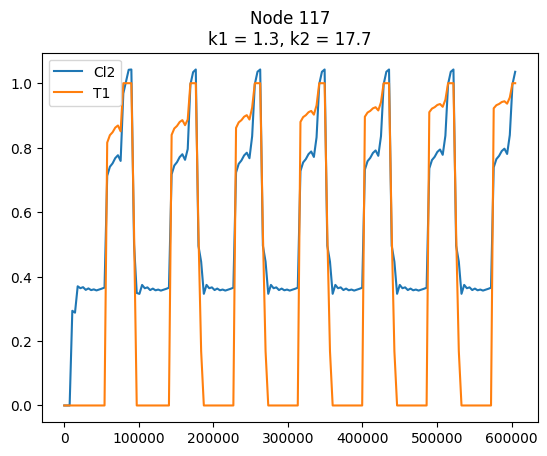

In [9]:
import matplotlib.pyplot as plt
_=wntr.graphics.plot_network(
    wn, node_attribute=res.node['T1'].loc[3600*12,:], 
    title='12 h', node_colorbar_label='River\nFraction',
)
_=wntr.graphics.plot_network(
    wn, node_attribute=res.node['T1'].loc[3600*24,:], 
    title='24 h', node_colorbar_label='River\nFraction',
)
_=wntr.graphics.plot_network(
    wn, node_attribute=res.node['T1'].loc[3600*36,:], 
    title='36 h', node_colorbar_label='River\nFraction',
)
query = '117'  # '191', '269', '117'
res.node['CL2'][query].plot()
res.node['T1'][query].plot()
plt.title('Node {}\nk1 = {:.1f}, k2 = {:.1f}'.format(query, k1.value, k2.value))
_=plt.legend(['Cl2', 'T1'])

### Look at impact of different k1 values on residuals

In [10]:
d_k1 = dict()
k1 = wn.msx.reaction_system.constants['k1']
for i in range(7):
    # Increase the reaction rate
    newk = 1.3 + i*2.6
    k1.value = newk
    resk = sim.run_sim()
    d_k1[newk] = resk

Text(0, 0.5, 'Concentraion [mg/L]')

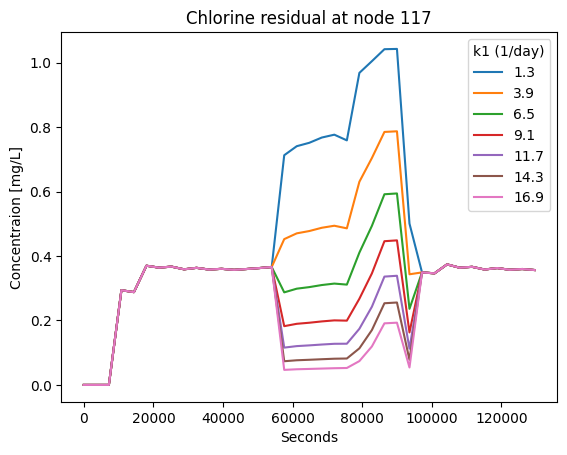

In [11]:
# res.node["T1"].loc[0:3600*36, query].plot(style='k.')
for newk, resk in d_k1.items():
    resk.node["CL2"].loc[0:3600*36, query].plot()
plt.legend(["{:.1f}".format(k) for k in d_k1.keys()], title="k1 (1/day)")
plt.title("Chlorine residual at node {}".format(query))
plt.xlabel('Seconds')
plt.ylabel('Concentraion [mg/L]')